In [155]:
import os
import pickle
from tqdm import tqdm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
!pip install Afinn
from afinn import Afinn 
afn = Afinn()

In [3]:
# Specifying filename and directory
data_dir = os.getcwd() + '\data'

In [7]:
df = pd.read_pickle(rf"{data_dir}\Quotebank_wSentiment.pkl", )

In [62]:
df.sentiment.describe()

count    34699.000000
mean         2.266117
std          5.411369
min        -45.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         89.000000
Name: sentiment, dtype: float64

In [57]:
def showQuote(index):
    print(df.quotation[index][df.index[min_score_idx][0]])

In [161]:
min_score_idx = df[df.sentiment == np.min(df.sentiment)].index
print("Quote with minimum sentiment:\n")
showQuote(min_score_idx)

Quote with minimum sentiment:

Suicide Squad is bad. Not fun bad. Not redeemable bad. Not the kind of bad that is the unfortunate result of artists honorably striving for something ambitious and falling short. Suicide Squad is just bad. It's ugly and boring, a toxic combination that means the film's highly fetishized violence doesn't even have the exciting tingle of the wicked or the taboo. (Oh, how the movie wants to be both of those things.) It's simply a dull chore steeped in flaccid machismo, a shapeless, poorly edited trudge that adds some mildly appalling sexism and even a soup & ccedil; on of racism to its abundant, hideously timed gun worship. But, perhaps worst of all, Suicide Squad is ultimately too shoddy and forgettable to even register as revolting. At least revolting would have been something.


In [160]:
max_score_idx = df[df.sentiment == np.max(df.sentiment)].index
print("Quote with maxmum sentiment:\n")
showQuote(max_score_idx)

Quote with maxmum sentiment:

Starring in Avengers: Infinity War is BAFTA Award nominee Chris Hemsworth as Thor, Academy Award nominee Josh Brolin as Thanos, Saturn Award Winner Chris Pratt as Star Lord / Peter Quill, Teen Choice Awards nominee Sebastian Stan as Bucky, four-time Golden Globe Award nominee Scarlett Johansson as Natasha Romanoff / Black Widow, Academy Award nominee Benedict Cumberbatch as Dr. Stephen Strange, Academy Award winner Brie Larson as Carol Danvers / Captain Marvel, ALMA Award winner Zoe Saldana as Gamora, Empire Award winner Karen Gillan as Nebula, two-time Academy Award nominee Jeremy Renner as Clint Barton / Hawkeye, two-time Saturn Award nominee Chris Evans as Steve Rogers / Captain America, BAFTA Awards nominee Elizabeth Olsen as Wanda Maximoff / Scarlet, four-time Academy Award nominee Bradley Cooper as Rocket Raccoon, Screen Actors Guild Awards nominee Vin Diesel as Groot, Academy Award nominee Samuel L. Jackson as Nick Fury, Screen Actors Guild Awards n

In [ ]:
def getPartOfDataFrame(df, start_date, end_date):
    df_dates = df[df['date'] >= start_date][df['date'] <= end_date]
    return df_dates

In [138]:
def sentimentAcrossDates(df, start_date='2019-01-01', end_date='2019-12-31'):
    df_dates = getPartOfDataFrame(df, start_date, end_date)
    date_range = df_dates.date
    unique_dates = np.unique(date_range)
    
    date_avgSentiment = ([(date, np.mean(df.query(f'date == "{date}"')[['date', 'sentiment']])) for date in tqdm(unique_dates)])
    dates, avgSentiments = list(zip(*date_avgSentiment))
    avgSentiments = np.concatenate(avgSentiments)
    
    return np.array(dates), avgSentiments

In [139]:
def smooth_filter(y, l=51):
    y_filtered = np.convolve(y, np.ones(l)/l, mode='same')
    return y_filtered

def moving_average(y, L_=200):
    y_filtered = []
    for s in range(L_,len(y)):
        y_filtered.append(np.mean(y[s-L_:s]))
    
    return y_filtered

In [140]:
def plotSentimentTimeseries(df, start_date, end_date):
    
    dates, unfiltered = sentimentAcrossDates(df, start_date=start_date, end_date=end_date)
    filtered_once = smooth_filter(unfiltered, 51)
    filtered_twice = smooth_filter(filtered_once, 21)
    
    months = ['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01']
    xtick_pos = np.round(np.arange(0, len(dates), step=len(dates)/12, dtype=int))

    fig, axs = plt.subplots(3, figsize=(12,8), sharex=True)

    axs[0].plot(np.arange(len(unfiltered)), unfiltered, '--.')
    axs[0].axhline(color='grey', linestyle='--')

    axs[1].plot(np.arange(len(filtered_once)), filtered_once)
    axs[1].plot(np.arange(len(filtered_once)), filtered_once-np.mean(filtered_once), '-')
    axs[1].axhline(color='grey', linestyle='--')
    axs[1].set_ylabel("Average sentiment", size=12)

    axs[2].plot(np.arange(len(filtered_twice)), filtered_twice, label='Lowpass')
    axs[2].plot(np.arange(len(filtered_twice)), filtered_twice-np.mean(filtered_twice), label='Lowpass with zero mean')
    axs[2].axhline(color='grey', linestyle='--', label='Neutral sentiment')

    plt.xlabel("Date", size=12)
    plt.xticks(xtick_pos, dates[xtick_pos], rotation=45)
    plt.legend(bbox_to_anchor=(1,1.45), loc="lower left")
    fig.suptitle(f"Daily sentiment of quotes between {start_date} and {end_date} \n(w. smoothness filter)", size=20)
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:07<00:00, 180.98it/s]


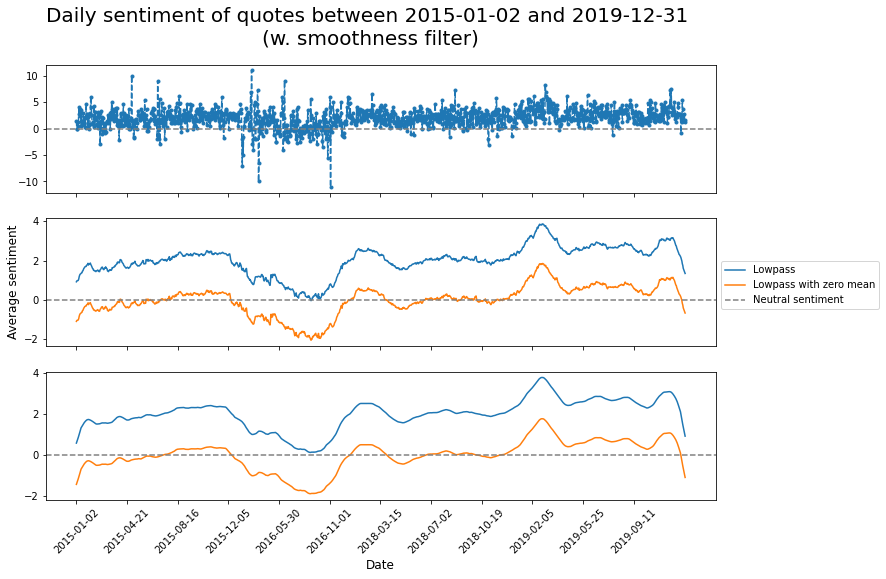

Dates range from 2015-01-02 to 2019-12-31 !


In [143]:
earliest_date = np.min(df.date)
latest_date = np.max(df.date)
plotSentimentTimeseries(df, earliest_date, latest_date)
print(f"Dates range from {earliest_date} to {latest_date} !")

In [145]:
start_date = '2015-10-15'
end_date = '2016-12-16'
df_dates = getPartOfDataFrame(df, start_date=start_date, end_date=end_date)

print(f"Dates range from {start_date} to {end_date} !")

Dates range from 2015-10-15 to 2016-12-16 !


<ipython-input-128-0b9877839a19>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_dates = df[df['date'] >= start_date][df['date'] <= end_date]


In [168]:
list(df_dates.loc[min_score_idx].shared_ID)[0]

954

In [173]:
min_score_idx = df_dates[df_dates.sentiment == np.min(df_dates.sentiment)].index
negative_speaker_ID = list(df_dates.loc[min_score_idx].shared_ID)[0]

min_mean = np.mean(df_dates.sentiment[df.shared_ID == negative_speaker_ID])
min_std = np.std(df_dates.sentiment[df.shared_ID == negative_speaker_ID])

print(f"Sentiment associated with speaker ID with minimum (single) sentiment:\n\n {min_mean} \pm {min_std}")

Sentiment associated with speaker ID with minimum (single) sentiment:

 -5.75 \pm 14.922717580923388


In [174]:
df_dates[df.shared_ID == negative_speaker_ID]

<ipython-input-174-6de5dc2c2da7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_dates[df.shared_ID == negative_speaker_ID]


,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,sentiment
6070,"Mockingjay: Part 2 shows us, in rich and braci...",Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2015-12-01,1,"[[Richard Lawson, 0.8551], [None, 0.1449]]",[http://barkingplanet.typepad.com/barking_plan...,The Hunger Games: Mockingjay - Part 2,954,9.0
6328,"This could easily have been a mess, but in nea...",Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2015-12-16,3,"[[Richard Lawson, 0.7884], [Joe Morgenstern, 0...",[http://www.masslive.com/entertainment/index.s...,Star Wars: Episode VII - The Force Awakens,954,4.0
9373,Somewhat free of the weight of expectations th...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-12-13,1,"[[Richard Lawson, 0.7865], [None, 0.2135]]",[http://nzherald.co.nz/entertainment/news/arti...,Rogue One,954,5.0
9494,Somewhat free of the weight of expectations th...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-12-13,1,"[[Richard Lawson, 0.9423], [None, 0.0577]]",[http://abcnews.go.com/Entertainment/critics-r...,Rogue One,954,5.0
9495,Somewhat free of the weight of expectations th...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-12-13,1,"[[Richard Lawson, 0.7739], [None, 0.2261]]",[http://www.darkhorizons.com/the-rogue-one-cri...,Rogue One,954,-2.0
9716,is bad. Not fun bad. Not redeemable bad. Not t...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-08-03,1,"[[Richard Lawson, 0.877], [None, 0.0937], [Dav...",[http://www.vanityfair.com/hollywood/2016/08/s...,Suicide Squad,954,-12.0
9725,"`Suicide Squad' is so uninspired, so dim and u...",Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-08-02,1,"[[Richard Lawson, 0.9134], [None, 0.0567], [Da...",[http://www.indiewire.com/2016/08/suicide-squa...,Suicide Squad,954,-7.0
10120,Suicide Squad is bad. Not fun bad. Not redeema...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-08-02,1,"[[Richard Lawson, 0.9545], [None, 0.0434], [Ma...",[http://cosmopolitan.com.au/health-lifestyle/l...,Suicide Squad,954,-14.0
10327,bad. Not fun bad. Not redeemable bad. Not the ...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-08-03,1,"[[Richard Lawson, 0.9502], [None, 0.0498]]",[http://rappler.com/entertainment/movies/14177...,Suicide Squad,954,-12.0
10482,Rather than bringing levity and irreverence to...,Richard Lawson,"[Q16231400, Q7327284, Q3934828, Q7327285, Q162...",2016-08-03,1,"[[None, 0.354], [Richard Lawson, 0.333], [Bren...",[http://www.reviewjournal.com/neon/movies-and-...,Suicide Squad,954,-1.0
